# Import Libraries

Numpy, Matplotlib, MNE


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.filter import notch_filter
%matplotlib qt
import csv
import pandas as pd

C:\Users\loicl\AppData\Local\Temp\ipykernel_34968\3981951788.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Channels marked as bad:
none
Channels marked as bad:
none


# Load Data

Paths to each absence data file is stored in absence_files.txt. An EDF data file will be loaded using the MNE library as an MNE raw object.


In [2]:
# Set data location
DEV_DATA_FOLDER = "E:/edf/dev"

# Set absence file names
ABSENCE_FILES_NAMES = []
with open(r"processed_data\absence\absence_files.txt", "r") as f:
    for i in f.readlines():
        ABSENCE_FILES_NAMES.append(DEV_DATA_FOLDER + i[:-1])

In [3]:
# Change index to change which absence seizure to load
def loadData(seizure_idx):
    raw_edf = mne.io.read_raw_edf(ABSENCE_FILES_NAMES[seizure_idx])
    return raw_edf

In [4]:
raw_edf = loadData(1)
raw_edf.load_data()

Extracting EDF parameters from E:\edf\dev\02_tcp_le\036\00003635\s001_2006_07_20\00003635_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 404499  =      0.000 ...  1617.996 secs...


Measurement date,"July 20, 2006 15:40:00 GMT"
Experimenter,Unknown
Participant,00003635
Digitized points,Not available
Good channels,33 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


Using matplotlib as 2D backend.


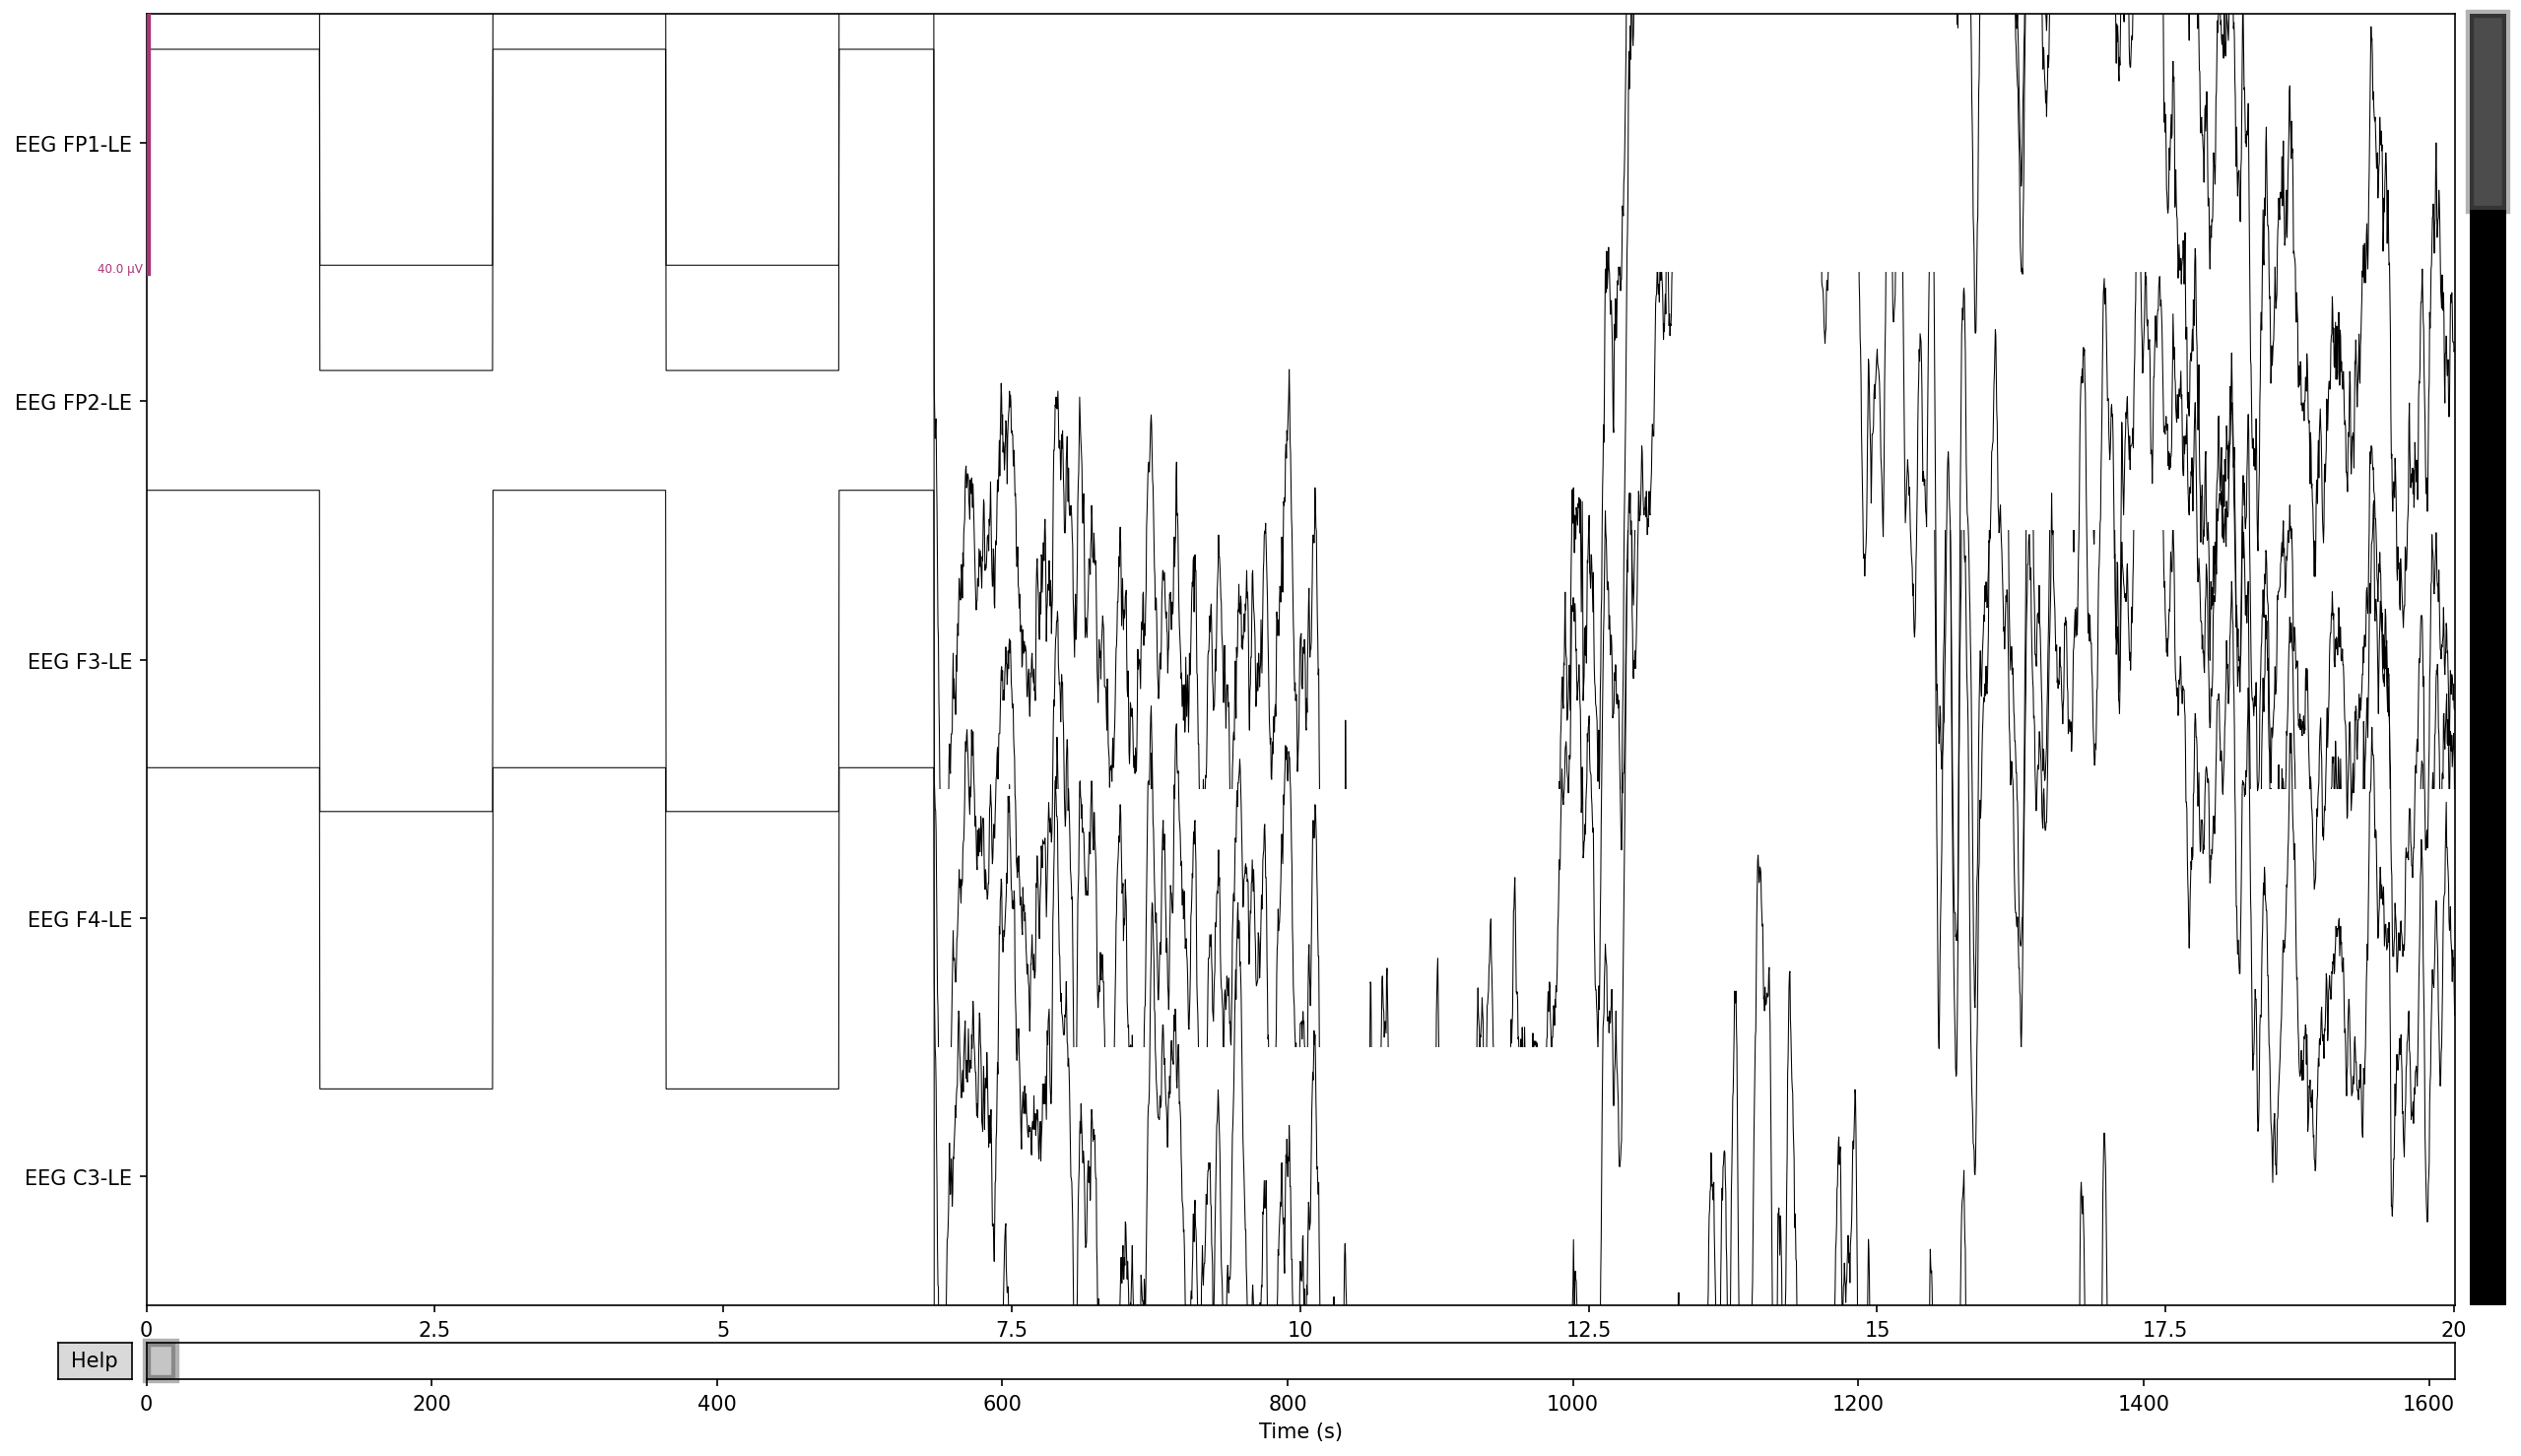

In [5]:
#Plot Data
%matplotlib qt
raw_edf.plot(duration=20, n_channels=5)


# Analyse


In [6]:
def plotFrquency(raw_edf):
    data, times = raw_edf.get_data(return_times=True)
    fft = np.fft.fft(data, axis=1)
    P2 = np.abs(fft / data.shape[1])
    P1 = P2[:, : data.shape[1] // 2]
    P1[:, 1:-1] = 2 * P1[:, 1:-1]
    f = np.linspace(0, 1 / (2 * times[1]), data.shape[1] // 2)
    plt.figure()
    plt.plot(f, P1[0, :])
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()

Effective window size : 8.192 (s)


C:\Users\loicl\AppData\Local\Temp\ipykernel_34968\3441860465.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_edf.compute_psd(fmax=125).plot(picks="data", exclude="bads", amplitude=False)


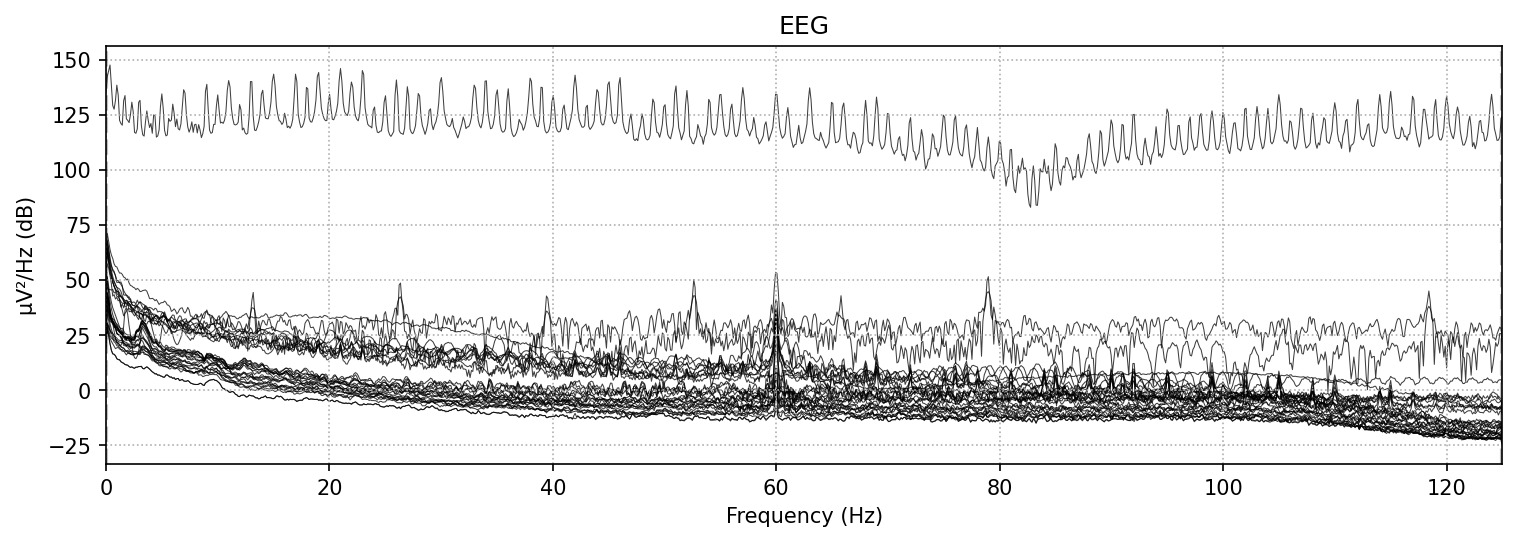

In [7]:
plotFrquency(raw_edf)
raw_edf.compute_psd(fmax=125).plot(picks="data", exclude="bads", amplitude=False)

# Preprocessing

```python
notch_filter(freqs, picks=None, filter_length='auto', notch_widths=None, trans_bandwidth=1.0, n_jobs=None, method='fir', iir_params=None, mt_bandwidth=None, p_value=0.05, phase='zero', fir_window='hamming', fir_design='firwin', pad='reflect_limited', skip_by_annotation=('edge', 'bad_acq_skip'), verbose=None)
```


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 8.192 (s)


C:\Users\loicl\AppData\Local\Temp\ipykernel_34968\3535530879.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_edf.compute_psd(fmax=125).plot(picks="data", exclude="bads")


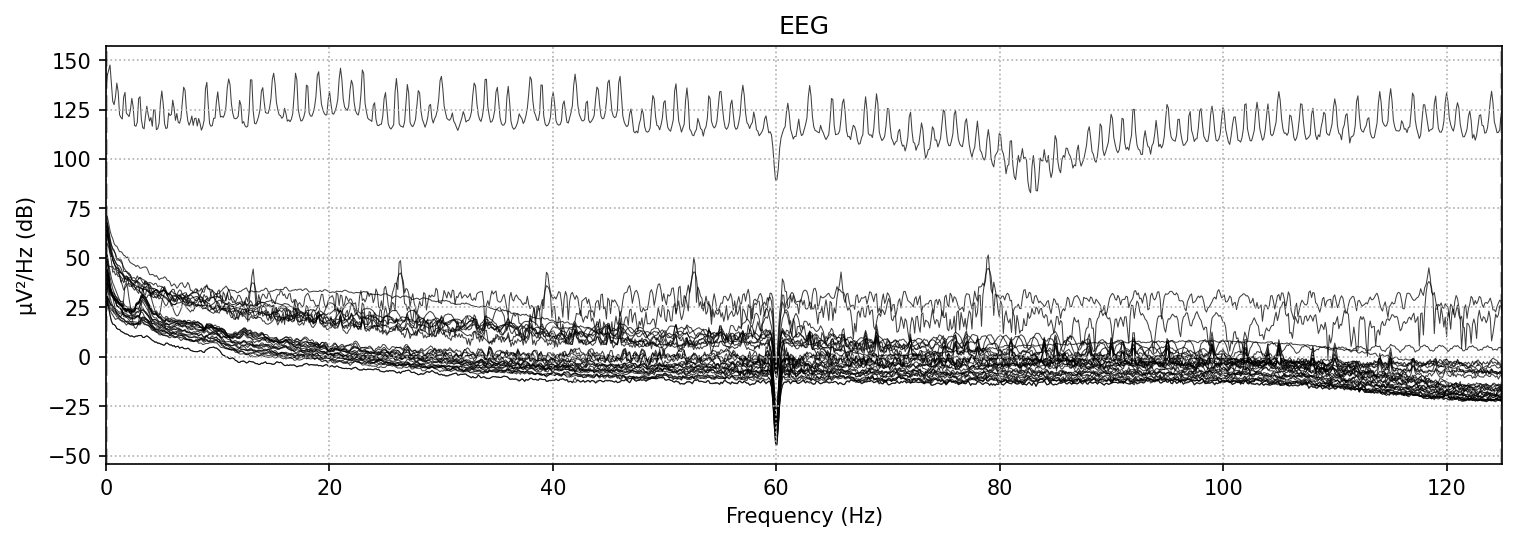

In [8]:
raw_edf.notch_filter(60)
plotFrquency(raw_edf)



raw_edf.compute_psd(fmax=125).plot(picks="data", exclude="bads")

In [9]:
raw_edf.plot(duration=20, n_channels=5)
plotFrquency(raw_edf)

# Split into Epochs


In [10]:
# raw_edf = mne.channels.combine_channels(
#     inst=raw_edf, groups=dict(comb=[1, 2, 3, 4]), method="std"
# )
epoch_duration = 4
epoch_overlap = 2
epochs = mne.make_fixed_length_epochs(
    raw_edf, duration=epoch_duration, overlap=epoch_overlap
)


# epochs.plot(n_epochs=20, n_channels=5)
epochs_vector = epochs.get_data()

Not setting metadata
808 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 808 events and 1000 original time points ...
0 bad epochs dropped


In [11]:
epochs_vector.shape

(808, 33, 1000)

# Create Labels


In [12]:
def format_annotations(annotations_file):
    annotations_list = []
    with open(annotations_file, "r") as f:
        for i, v in enumerate(f.readlines()):
            if i >= 2:
                row = v.split(" ")
                row.remove(row[-1])
                annotations_list.append(row)
    return annotations_list

In [13]:
# CHANGE ANNOTATIONS FOR EACH EEG
annotations = format_annotations(

    annotations_file=r"processed_data\absence\annotations\2\00003635_s001_t001.tse"
)
print(annotations)

[['0.0000', '199.0412', 'bckg'], ['199.0412', '202.4638', 'absz'], ['202.4638', '312.0223', 'bckg'], ['312.0223', '315.0658', 'absz'], ['315.0658', '610.1171', 'bckg'], ['610.1171', '612.1572', 'absz'], ['612.1572', '756.9264', 'bckg'], ['756.9264', '760.1148', 'absz'], ['760.1148', '863.7146', 'bckg'], ['863.7146', '865.7046', 'absz'], ['865.7046', '1067.1293', 'bckg'], ['1067.1293', '1070.6633', 'absz'], ['1070.6633', '1127.3501', 'bckg'], ['1127.3501', '1129.3289', 'absz'], ['1129.3289', '1618.0000', 'bckg']]


In [14]:
# 0 = no seizure, 1 = absence seizure
def create_labels(raw_edf, annotations):
    data, time = raw_edf.get_data(return_times=True)
    duration_seconds = time[-1]

    events = {}
    for i in range(int(len(time) / 250)):
        for j in annotations:
            if i in range(int(float(j[0])), int(float(j[1]))):
                if j[2] == "bckg":
                    events[i * 250] = 0
                elif j[2] == "absz":
                    events[i * 250] = 1

    return events

In [15]:
events = create_labels(raw_edf, annotations)

In [16]:
def scale_labels_to_epochs(epochs, events):
    epoch_labels = [None] * len(epochs.get_data())

    for i in range(0, len(epochs.get_data()), 2):
        epoch_labels[i] = events[i * 250]

    for i, v in enumerate(epoch_labels):
        if v == None:
            if i != len(epoch_labels) - 1:
                if epoch_labels[i - 1] == 0 and epoch_labels[i + 1] == 0:
                    epoch_labels[i] = 0
                elif epoch_labels[i - 1] == 1 and epoch_labels[i + 1] == 1:
                    epoch_labels[i] = 1
                else:
                    epoch_labels[i] = 1
            else:
                if epoch_labels[i - 1] == 0:
                    epoch_labels[i] = 0
                elif epoch_labels[i - 1] == 1:
                    epoch_labels[i] = 1

    return epoch_labels

In [17]:
labels = scale_labels_to_epochs(epochs, events)

print(len(labels))
print(len(epochs))

Using data from preloaded Raw for 808 events and 1000 original time points ...
Using data from preloaded Raw for 808 events and 1000 original time points ...


808
808


# Save to CSV


In [18]:
# with open(r"processed_data\absence\absence_data.csv", "w", newline="") as file:
#     write = csv.writer(file)
#     write.writerow(['seizure_type', 'seizure_data'])

epochs_vector = epochs.get_data()
np.save(r"processed_data\absence\absence_data.npy", epochs_vector)
np.save(r"processed_data\absence\absence_data_labels.npy", labels)

Using data from preloaded Raw for 808 events and 1000 original time points ...


In [19]:
# np.set_printoptions(linewidth=10000)
# with open(r"processed_data\absence\absence_data.csv", "a") as file:
#     write = csv.writer(file)
#     for i, v in enumerate(labels):
#         write.writerow([v, epochs_vector[i][0]])